Author: Michael Stoll\
6/5/2024\
\
As before, I am referencing the work of others fairly often as I work through this.\
The motivation behind the code below is to evaluate the performance of different preprocessing methods to improve the quality of a data set.

In [1]:
import sklearn
from sklearn import preprocessing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer

data = pd.read_csv("Global_Landslide_Catalog_Export_20240605.csv", sep=",")

I've had to manipulate the csv into numerical format to get it to work properly. An unedited copy will also be included in the repo, as well as the set I'm actually working with, which is the same set but minus the irrelevant data points (country of origin, news story publisher, etc.)\
The data points that remain are Trigger (cause of the landslide), Size (self-explanatory), Injuries (ibid), and Fatalites(ibid).
For my sanity and your readability, I'm going to list the numerical representations of the data I'm translating here:\
Trigger: unknown = 0, rain = 1, downpour = 2, monsoon = 3, continuous_1 = 4, tropical_cyclone = 5, other = 6.\
Size: unknown = 0, small = 1, medium = 2, large = 3, very_large = 4, catastrophic = 5.
\
\
Now that basic imports are done, it's time to get into the actual preprocessing. Something that I saw in Wolff's repo was a consolidated function for display purposes, which seemed like a good idea to me. So that's what this is.\
I'm focusing almost entirely on the info and the heatmap, because I feel that I can get my point across clearly by showing the correlation between the different variables, and the count of the non-null data points is going to be relevant in the future.

In [2]:
def build(cleanedData):
    df = pd.DataFrame(cleanedData)
    #df.describe()
    df.info()
    plt.show()
    sns.heatmap(df.corr(), square = True, annot= True, linewidths=.1, vmax=1, linecolor='black', cmap='Grays')
    plt.show()

Since it's always a good idea to start with a control, I'm going to go ahead and just send the baseline data through and see what happens.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11033 entries, 0 to 11032
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   trigger     11010 non-null  float64
 1   size        11024 non-null  float64
 2   fatalities  9648 non-null   float64
 3   injuries    5359 non-null   float64
dtypes: float64(4)
memory usage: 344.9 KB


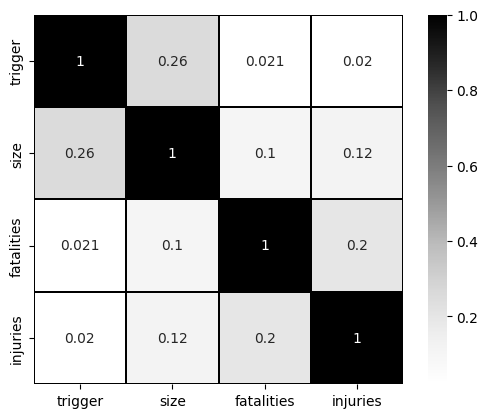

In [3]:
build(data)

As could be reasonably expected, there is no strong correlation between any of the variables, with the correlation between trigger and size being the strongest. Of course, this is raw data, and that's the whole point of this entire assignment. I have a few ideas on how I could strengthen the correlations.\
\
First of all, and not for nothing, the counts in the info window for non-null values fluctuate pretty wildly. For example, over half of the data points provided have no data point for injuries. For each one of these entries, the correlation would likely be skewed in one direction or another by the remaining data that isn't null. So, a logical next step seems to me to be to get rid of these entries and work with only entries that have data for all four entries.\
Luckily, there is a built in function that does exactly that, so my job in this step is easy.

<class 'pandas.core.frame.DataFrame'>
Index: 5325 entries, 11 to 11032
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   trigger     5325 non-null   float64
 1   size        5325 non-null   float64
 2   fatalities  5325 non-null   float64
 3   injuries    5325 non-null   float64
dtypes: float64(4)
memory usage: 208.0 KB


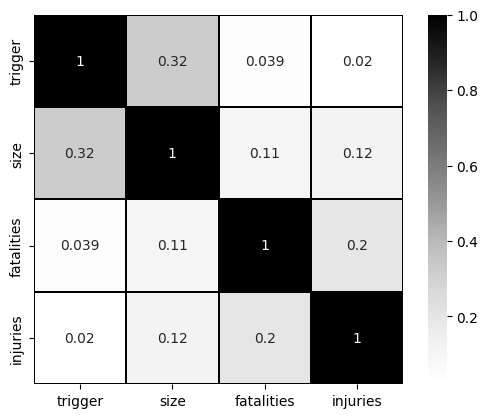

In [4]:
newData = data.dropna()

build(newData)

As you can see, all of the entries that had one or more null values has now been removed from the dataset. This, as I expected, had the effect of strengthening several of the correlations on the heatmap, which means I'm making some progress.\
However, 32% isn't that much stronger than 26%. Clearly this data still needs some work done to it to be of much use.\
This being real-world data, the next thing that stuck out to me was the prevalence of entries that didn't have reported triggers or sizes. Going into this, I don't know if that would cause the same sort of correlation skew that the previous step corrected, but I suspect that it will.\
\
(Also, for the sake of evaluating these strategies individually, I am going to run them separately on the raw data and see how they turn out. Just in case you were wondering.)

<class 'pandas.core.frame.DataFrame'>
Index: 9269 entries, 0 to 11032
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   trigger     9246 non-null   float64
 1   size        9260 non-null   float64
 2   fatalities  7940 non-null   float64
 3   injuries    3761 non-null   float64
dtypes: float64(4)
memory usage: 362.1 KB


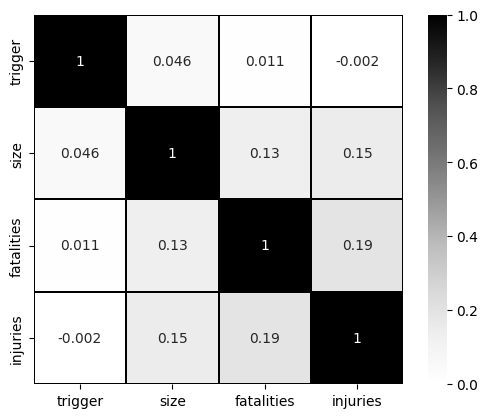

In [5]:
newerData = data.drop(data[(data['trigger'] ==0) | (data['size'] == 0)].index)

build(newerData)

Clearly, this is beginning to head in the wrong direction. Just to verify, I'm going to run it on the dataset I had left after the previous step, to see if somehow they complement each other well.

<class 'pandas.core.frame.DataFrame'>
Index: 3727 entries, 13 to 11032
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   trigger     3727 non-null   float64
 1   size        3727 non-null   float64
 2   fatalities  3727 non-null   float64
 3   injuries    3727 non-null   float64
dtypes: float64(4)
memory usage: 145.6 KB


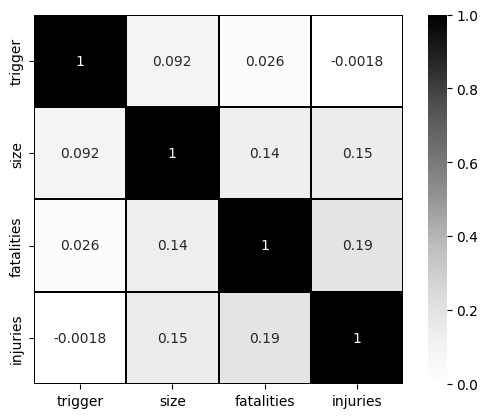

In [6]:
newerData = newData.drop(newData[(newData['trigger'] == 0) | (newData['size'] == 0)].index)

build(newerData)

Since we've confirmed that this isn't a good strategy, it's now time to scrap the idea and move on to another one.\
It seems reasonable to get rid of any obvious outliers, so that will be next on the list.\
For some reason, I'm struggling to get these display elements to work together, so I'm going to separate them into their own cells.

In [7]:
#newData[data.duplicated()]
newData['fatalities'].describe()
#newData['fatalities'].plot()

count    5325.000000
mean        1.930892
std        30.967606
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2100.000000
Name: fatalities, dtype: float64

<Axes: >

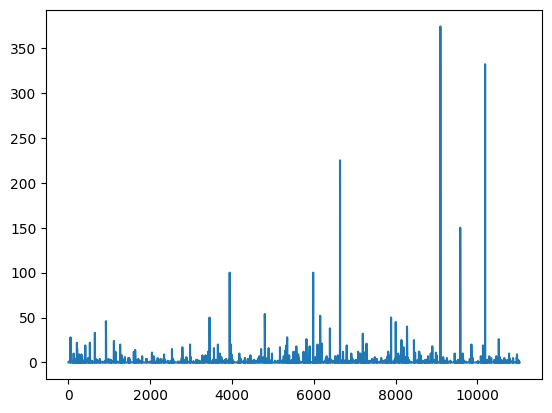

In [8]:
newData['injuries'].describe()
newData['injuries'].plot()

Clearly, there are some major outliers in this data set. I have never seen a max value that was over 1000x the mean value before now. But, this step should be pretty easy to clean up, all things considered. All we have to do is cut off the bell curve at a point that makes sense.\
After some short deliberation, I decided that staying within one standard deviation of the mean score makes sense (since, if I remember correctly, that accounts for ~96% of all data) makes sense. Since we're working with integers, I didn't do the exact math, but the concept remains that I'm dropping anything that was over one standard deviation away from the mean.

In [9]:
#newerData = newData.drop(newData[(newData['fatalities'] > 62) | (newData['injuries'] > 17)].index)
newerData = newData.drop(newData[(newData['fatalities'] > 33) | (newData['injuries'] > 10)].index)
#newerData['injuries'].plot()
newerData['injuries'].describe()

count    5225.000000
mean        0.258756
std         1.054975
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: injuries, dtype: float64

In [10]:
#newerData['fatalities'].plot()
newerData['fatalities'].describe()

count    5225.000000
mean        0.664115
std         2.319087
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        33.000000
Name: fatalities, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Index: 5225 entries, 11 to 11032
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   trigger     5225 non-null   float64
 1   size        5225 non-null   float64
 2   fatalities  5225 non-null   float64
 3   injuries    5225 non-null   float64
dtypes: float64(4)
memory usage: 204.1 KB


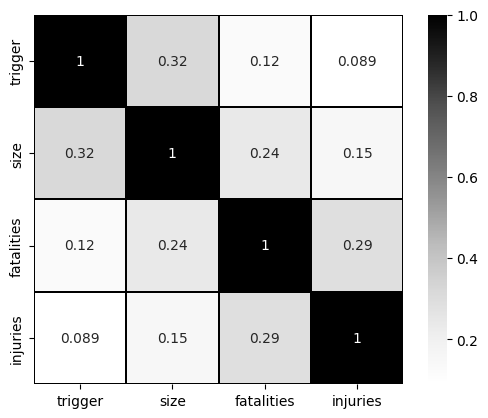

In [11]:
build(newerData)

We're back on the right track. There still isn't a correlation above 50%, which is a little disheartening, but we are well above where we were. Ultimately, that may just come down to the nature of the data and what it represents. Maybe there just isn't a regression that can accurately match trigger of landslide to number of injuries with any real accuracy.\
\
I know this isn't complete, that I need to make a report from what I have here, but this is the part where I could really use some feedback. A few things in specific would help, if you don't mind:\
\
Most of what is in the comments here will end up in the report. In addition, I will be very clear about the objective (presenting a better data set than I was given) and the nature of the dataset. What else would you like to be included?\
\
Am I on the right track with the methods I've chosen? I know this is supposed to be simple, but removing null values and outliers feels maybe too trivial for an assignment. Would you prefer other methods, or perhaps just more? Any suggestions on where to glean said methods?\
\
Thank you for your time. 